In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from commando import ComManDo
from commando.evaluation import generate_figure, test_partial
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

2022-03-02 02:41:07.227681: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-02 02:41:07.227715: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
data1 = np.loadtxt("../data/UnionCom/scGEM/GeneExpression.txt")
data2 = np.loadtxt("../data/UnionCom/scGEM/DNAmethylation.txt")
type1 = np.loadtxt("../data/UnionCom/scGEM/type1.txt")
type2 = np.loadtxt("../data/UnionCom/scGEM/type2.txt")
type1 = type1.astype(np.int)
type2 = type2.astype(np.int)
type_func = lambda x: {1:'BJ', 2:'d8', 3:'d16T+', 4:'d24T+', 5:'IPS'}[x]

# ComManDo Aligned

In [4]:
cm = ComManDo()
cm_data = cm.fit_transform(dataset=[data1,data2])

use random seed: 666
Shape of Raw data
Dataset 0: (177, 34)
Dataset 1: (177, 27)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[100/2000] err:3.6545 alpha:1.0122
epoch:[200/2000] err:2.9233 alpha:1.1805
epoch:[300/2000] err:2.0462 alpha:1.3132
epoch:[400/2000] err:1.6937 alpha:1.3747
epoch:[500/2000] err:1.5626 alpha:1.4014
epoch:[600/2000] err:1.5047 alpha:1.4145
epoch:[700/2000] err:1.4725 alpha:1.4224
epoch:[800/2000] err:1.4507 alpha:1.4282
epoch:[900/2000] err:1.4341 alpha:1.4329
epoch:[1000/2000] err:1.4207 alpha:1.4369
epoch:[1100/2000] err:1.4093 alpha:1.4405
epoch:[1200/2000] err:1.3993 alpha:1.4436
epoch:[1300/2000] err:1.3907 alpha:1.4463
epoch:[1400/2000] err:1.3833 alpha:1.4488
epoch:[1500/2000] err:1.3769 alpha:1.4510
epoch:[1600/2000] err:1.3714 alpha:1.4530
epoch:[1700/2000] err:1.3668 alpha:1.4549
epoch:[1800/2000] err:1.3629 alpha:1.4565
epoch:[1900/2000] err:1.3594 alpha:1.4580
epoch:[2000/2000] err:1.3564 alp

# UnionCom Unaligned

In [5]:
uc = ComManDo(project_mode='tsne')
uc_data = uc.fit_transform(dataset=[data1,data2])

use random seed: 666
Shape of Raw data
Dataset 0: (177, 34)
Dataset 1: (177, 27)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[100/2000] err:3.6545 alpha:1.0122
epoch:[200/2000] err:2.9233 alpha:1.1805
epoch:[300/2000] err:2.0462 alpha:1.3132
epoch:[400/2000] err:1.6937 alpha:1.3747
epoch:[500/2000] err:1.5626 alpha:1.4014
epoch:[600/2000] err:1.5047 alpha:1.4145
epoch:[700/2000] err:1.4725 alpha:1.4224
epoch:[800/2000] err:1.4507 alpha:1.4282
epoch:[900/2000] err:1.4341 alpha:1.4329
epoch:[1000/2000] err:1.4207 alpha:1.4369
epoch:[1100/2000] err:1.4093 alpha:1.4405
epoch:[1200/2000] err:1.3993 alpha:1.4436
epoch:[1300/2000] err:1.3907 alpha:1.4463
epoch:[1400/2000] err:1.3833 alpha:1.4488
epoch:[1500/2000] err:1.3769 alpha:1.4510
epoch:[1600/2000] err:1.3714 alpha:1.4530
epoch:[1700/2000] err:1.3668 alpha:1.4549
epoch:[1800/2000] err:1.3629 alpha:1.4565
epoch:[1900/2000] err:1.3594 alpha:1.4580
epoch:[2000/2000] err:1.3564 alp

# Figure Generation

use random seed: 666
Shape of Raw data
Dataset 0: (177, 34)
Dataset 1: (177, 27)
Device: cpu
---------------------------------
Find correspondence between Dataset 1 and Dataset 2
epoch:[100/2000] err:3.6545 alpha:1.0122
epoch:[200/2000] err:2.9233 alpha:1.1805
epoch:[300/2000] err:2.0462 alpha:1.3132
epoch:[400/2000] err:1.6937 alpha:1.3747
epoch:[500/2000] err:1.5626 alpha:1.4014
epoch:[600/2000] err:1.5047 alpha:1.4145
epoch:[700/2000] err:1.4725 alpha:1.4224
epoch:[800/2000] err:1.4507 alpha:1.4282
epoch:[900/2000] err:1.4341 alpha:1.4329
epoch:[1000/2000] err:1.4207 alpha:1.4369
epoch:[1100/2000] err:1.4093 alpha:1.4405
epoch:[1200/2000] err:1.3993 alpha:1.4436
epoch:[1300/2000] err:1.3907 alpha:1.4463
epoch:[1400/2000] err:1.3833 alpha:1.4488
epoch:[1500/2000] err:1.3769 alpha:1.4510
epoch:[1600/2000] err:1.3714 alpha:1.4530
epoch:[1700/2000] err:1.3668 alpha:1.4549
epoch:[1800/2000] err:1.3629 alpha:1.4565
epoch:[1900/2000] err:1.3594 alpha:1.4580
epoch:[2000/2000] err:1.3564 alp

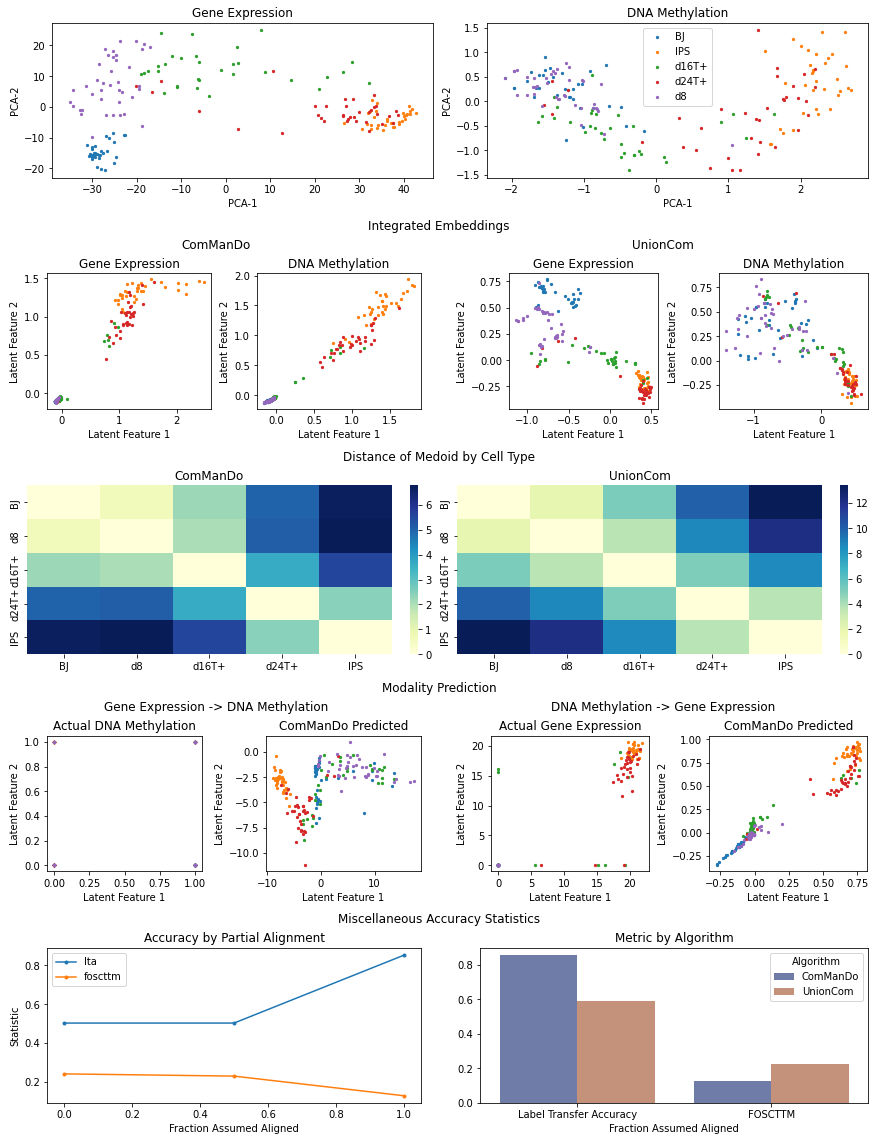

In [6]:
dataset = [data1, data2]
labels = [np.array([type_func(j) for j in i]) for i in (type1,type2)]
params = {
    'dataset_names': ['Gene Expression', 'DNA Methylation'],
    'alg_results': [uc_data],
    'alg_names': ['UnionCom'],
}
generate_figure(cm, cm_data, dataset, labels, **params)